# Ćwiczenie 3

Celem ćwiczenia jest imlementacja metody [Minimax z obcinaniem alpha-beta](https://en.wikipedia.org/wiki/Alpha%E2%80%93beta_pruning) do gry Connect Four (czwórki).

W trakcie ćwiczenia można skorzystać z reposytorium z implementacją gry [Connect Four udostępnionym przez Jakuba Łyskawę](https://github.com/lychanl/two-player-games). Ewentualnie, można zaimplementować samemu grę Connect Four (ale, tak aby rozwiązanie miało ten sam interfejs co podany poniżej).

Implementację Minimax należy przetestować używając różną głębokość przeszukiwania. Implementacja Solvera musi zapewniać interfejs jak poniżej, ale można dodać dowolne metody prywatne oraz klasy wspomagające (jeżeli będą potrzebne).

Punktacja:
- Działająca metoda Minimax - **2 pkt**
- Działająca metoda Minimax z obcinaniem alpha-beta - **1.5 pkt**
- Analiza jakości solvera w zależności od głębokości przeszukiwania **1.5pkt**
    - należy zaimplementować w tym celu prostą wizualizację rozgrywki dwóch agentów, bądź kilka przykładów 'z ręki'
- Jakość kodu **2pkt**

Aby importowanie elementów z poniższej komórki działało należy umieścić tego notebooka w tym samym folderze co paczkę `two_player_games`:
```
├── LICENSE
├── README.md
├── minimax.ipynb # <<< HERE
├── test
│   ├── __init__.py
│   ├── test_connect_four.py
│   ├── test_dots_and_boxes.py
│   └── test_pick.py
└── two_player_games
    ├── __init__.py
    ├── games
    │   ├── connect_four.py
    │   └── dots_and_boxes.py
    ├── move.py
    ├── player.py
    └── state.py
```

In [2]:
from typing import Tuple, List
from matplotlib import pyplot as plt

from two_player_games.player import Player
from two_player_games.games.connect_four import ConnectFour, ConnectFourMove, ConnectFourState

Wielkość planszy

In [3]:
ROW_COUNT = 6
COLUMN_COUNT = 7

Implementacja algorytmu minimax

In [4]:
class MinMaxSolver:

    def __init__(self, game:ConnectFour, player:Player, depth:int, alphabeta:bool):
        self.game = game
        self.player = player
        self.depth = depth
        self.alphabeta = alphabeta

    def _evaluate_position(self, game_state:ConnectFourState)->float:
        fours_on_board = self._get_all_fours(game_state)
    
        position_value = 0
        for four in fours_on_board:
            position_value += self._evaluate_four(four)

        return position_value
        

    def _evaluate_four(self, four:List[Player])->float:
        player_in_four = four.count(self.player)
        none_in_four = four.count(None)
        other_player_in_four = 4 - player_in_four - none_in_four
        
        if other_player_in_four == 0:  # only player
            return 100**player_in_four
        elif player_in_four == 0: # only other player
            return (100**other_player_in_four)*-1
        else:
            return 0
        
        
    def _get_all_fours(self, game_state:ConnectFourState) -> List[List[Player]]:
        board = game_state.fields
        columns = len(board)
        rows = len(board[0])
        
        fours = []

        for column in range(columns - 3): # horizontals
            for row in range(rows):
                fours.append([board[column + i][row] for i in range(4)])

        for column in range(columns): # verticals
            for row in range(rows - 3):
                fours.append([board[column][row + i] for i in range(4)])

        for column in range(columns - 3): # diagonals
            for row in range(rows - 3):
                fours.append([board[column + i][row + i] for i in range(4)])
                fours.append([board[column + 3 - i][row + i] for i in range(4)])
        
        return fours
        

    def get_best_move(self)->ConnectFourMove:        
        if self.alphabeta:
            best_move, _ = self._alphabeta(self.game.state, self.depth, alpha=float('-inf'), beta=float('inf'), is_maximizing_player=True)
        else:
            best_move, _ = self._minimax(self.game.state, self.depth, is_maximizing_player=True)
        return best_move


    def _is_valid_move(self, game_state:ConnectFourState, move:ConnectFourMove)->bool:
        return move in self._get_valid_moves(game_state)
    

    def _alphabeta(self, game_state:ConnectFourState, depth:int, alpha:float, beta:float, is_maximizing_player:bool)-> Tuple[ConnectFourMove, float]:
        if depth == 0 or game_state.is_finished():
            return None, self._evaluate_position(game_state)
        
        if is_maximizing_player:
            moves_value = []
            for move in self._get_valid_moves(game_state):
                new_state = game_state.make_move(move)
                _, value = self._alphabeta(new_state, depth-1, alpha, beta, False)
                alpha = max(alpha, value)
                moves_value.append((move, value))
                if beta <= alpha:
                    break
            return max(moves_value, key=lambda x: x[1])
        else:
            moves_value = []
            for move in self._get_valid_moves(game_state):
                new_state = game_state.make_move(move)
                _, value = self._alphabeta(new_state, depth-1, alpha, beta, True)
                beta = min(beta,value)
                moves_value.append((move, value))
                if beta <= alpha:
                    break
            return min(moves_value, key=lambda x: x[1])
    
    
    def _minimax(self, game_state:ConnectFourState, depth:int, is_maximizing_player:bool)-> Tuple[ConnectFourMove, float]:
        if depth == 0 or game_state.is_finished():
            return None, self._evaluate_position(game_state)
        
        if is_maximizing_player:
            moves_value = []
            for move in self._get_valid_moves(game_state):
                new_state = game_state.make_move(move)
                _, value = self._minimax(new_state, depth-1, False)
                moves_value.append((move, value))
            return max(moves_value, key=lambda x: x[1])
        else:
            moves_value = []
            for move in self._get_valid_moves(game_state):
                new_state = game_state.make_move(move)
                _, value = self._minimax(new_state, depth-1, True)
                moves_value.append((move, value))
            return min(moves_value, key=lambda x: x[1])
    

    def _get_valid_moves(self, game_state:ConnectFourState) -> List[ConnectFourMove]:
        return game_state.get_moves()
    

Funkcje pomocnicze to testowania algorytmu

In [4]:
import gc
import time
class Timer:
  def __init__(self):
    self._start_time = 0
    self._stop_time = 0
    self._gc_old = None

  def start(self):
    _gc_old = gc.isenabled()
    gc.disable()
    self._start_time = time.process_time()

  def stop(self):
    self._stop_time = time.process_time()
    if self._gc_old:
      gc.enable()

  def get_time(self):
    return self._stop_time - self._start_time

In [5]:
import random
from itertools import product
def all_possible_positions(game:ConnectFour):
    positions = []
    for move in list(product(range(0,COLUMN_COUNT),range(0,COLUMN_COUNT))):
        positions.append(game.state.make_move(ConnectFourMove(move[0])).make_move(ConnectFourMove(move[1])))
    return positions

def play(game, player_a, player_b, player_a_solver, player_b_solver):
    while not game.is_finished():
        if game.get_current_player() is player_a:    
            move = player_a_solver.get_best_move()
            game.make_move(move)
        else:
            move = player_b_solver.get_best_move()
            game.make_move(move)

Porónanie czasu rozgrywki dla algorytmu z obcinaniem alfa-beta i bez

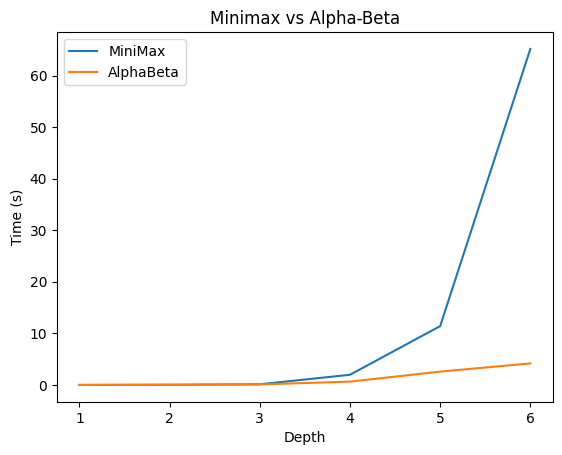

In [6]:
player_a = Player("a")
player_b = Player("b")
game = ConnectFour(size=(COLUMN_COUNT, ROW_COUNT), first_player=player_a, second_player=player_b)
state_snapshot = random.choice(all_possible_positions(game))
timer = Timer()

minimax_game_duration = []
for depth in range(1,7):

    game.state = state_snapshot

    player_a_solver = MinMaxSolver(game, player_a, depth, False)
    player_b_solver = MinMaxSolver(game, player_b, depth, False)

    timer.start()
    play(game, player_a, player_b, player_a_solver, player_b_solver)
    timer.stop()

    minimax_game_duration.append((depth, timer.get_time()))

alphabeta_game_duration = []
for depth in range(1,7):

    game.state = state_snapshot
    player_a_solver = MinMaxSolver(game, player_a, depth, True)
    player_b_solver = MinMaxSolver(game, player_b, depth, True)

    timer.start()
    play(game, player_a, player_b, player_a_solver, player_b_solver)
    timer.stop()

    alphabeta_game_duration.append((depth, timer.get_time()))


plt.ylabel("Time (s)")
plt.xlabel("Depth")
plt.title("Minimax vs Alpha-Beta")
depth_, time_ = zip(*minimax_game_duration)
plt.plot(depth_, time_, label='MiniMax')
depth_, time_ = zip(*alphabeta_game_duration)
plt.plot(depth_, time_, label='AlphaBeta')
plt.legend()
plt.show()

Wyniki rozgrywki w zależności od głębokości algorytmu

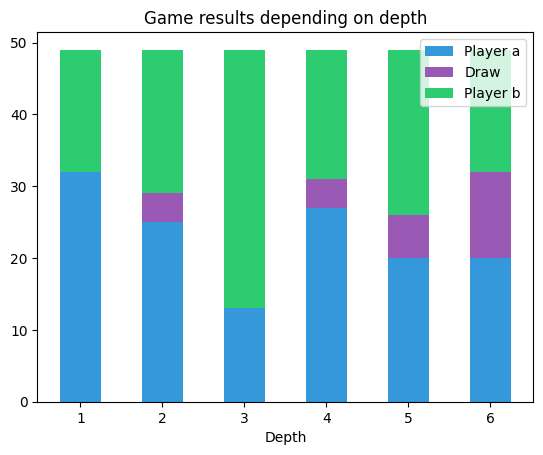

In [8]:
player_a = Player("a")
player_b = Player("b")
game = ConnectFour(size=(COLUMN_COUNT, ROW_COUNT), first_player=player_a, second_player=player_b)

positions = all_possible_positions(game)
depths = range(1,7)  

for depth in depths:

    winner = []
    for state in positions:
        game.state = state
        player_a_solver = MinMaxSolver(game, player_a, depth, True)
        player_b_solver = MinMaxSolver(game, player_b, depth, True)
        
        play(game, player_a, player_b, player_a_solver, player_b_solver)
        winner.append(game.get_winner())

    win_a = winner.count(player_a)
    win_b = winner.count(player_b)
    draw = winner.count(None)
    plt.bar(depth, win_a, 0.5, 0, color='#3498db')
    plt.bar(depth, draw, 0.5, win_a, color='#9b59b6')
    plt.bar(depth, win_b, 0.5, win_a + draw, color='#2ecc71')
plt.xticks(depths)
plt.xlabel('Depth')
plt.title('Game results depending on depth')
plt.legend(['Player a', 'Draw', 'Player b'])

Przykładowa rozgrywka krok po kroku

In [10]:
import random
player_a = Player("a")
player_b = Player("b")
game = ConnectFour(size=(COLUMN_COUNT, ROW_COUNT), first_player=player_a, second_player=player_b)
player_a_solver = MinMaxSolver(game, player_a, 7, True)
player_b_solver = MinMaxSolver(game, player_b, 7, True)

for i in range(6):
    game.make_move(ConnectFourMove(random.randint(0,COLUMN_COUNT-1)))

print(game, end='\n\n')
while not game.is_finished():
    if game.get_current_player() is player_a:    
        move = player_a_solver.get_best_move()
        game.make_move(move)
    else:
        move = player_b_solver.get_best_move()
        game.make_move(move)
    print(game, end='\n\n')


print("Draw" if game.get_winner() is None else f'Winner: Player {game.get_winner().char}')

Current player: a
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[b][ ][ ][ ][ ][ ][b]
[a][ ][b][ ][ ][a][a]

Current player: b
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[b][ ][a][ ][ ][ ][b]
[a][ ][b][ ][ ][a][a]

Current player: a
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][b][ ][ ][ ][ ]
[b][ ][a][ ][ ][ ][b]
[a][ ][b][ ][ ][a][a]

Current player: b
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][b][ ][ ][ ][ ]
[b][ ][a][ ][ ][ ][b]
[a][ ][b][a][ ][a][a]

Current player: a
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][b][ ][ ][ ][ ]
[b][ ][a][ ][ ][ ][b]
[a][ ][b][a][b][a][a]

Current player: b
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][b][ ][ ][ ][ ]
[b][ ][a][a][ ][ ][b]
[a][ ][b][a][b][a][a]

Current player: a
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][ ][ ][ ][ ][ ]
[ ][ ][b][